In this notebook, we add the examples for SEI8R:

## SEI8R
![Screenshot_2020-05-12_at_23.12.25](https://gitlab.com/camsofties/covid19//uploads/4cf3142dd1f83c9d51721232a9cc138f/Screenshot_2020-05-12_at_23.12.25.png)

 

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy import optimize

In [3]:
## population and age classes
M=16  ## number of age classes
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
Ni = (my_data[:, 1]+ my_data[:, 2])[0:M]

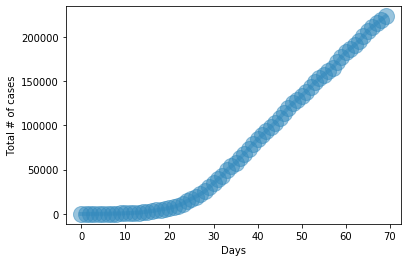

In [4]:
my_data = np.genfromtxt('../data/covid-cases/uk.txt', delimiter='', skip_header=0)
totCases = my_data[:,1]
plt.plot(totCases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.ylabel('Total # of cases')
plt.xlabel('Days');

In [5]:
# Get individual contact matrices
CH, CW, CS, CO = pyross.contactMatrix.India()

# Generate class with contact matrix for SIR model with UK contact structure
generator = pyross.contactMatrix.ContactMatrixFunction(CH, CW, CS, CO)


Tf=370;  Nf=600 
times= [21, Tf] # temporal boundaries between different contact-behaviour
aW, aS, aO = 0.3, 0.2, 0.8

# prefactors for CW, CS, CO:
interventions = [[1.0,1.0,1.0],      # before first time
                 [aW, aS, aO],       # between first and second time
                ]         

# generate corresponding contact matrix function
contactMatrix = generator.interventions_temporal(times=times,interventions=interventions)

## SEI8R

In [6]:
beta  = 0.01492            # infection rate 

gE    = 1/5
gIa   = 1./7                # removal rate of asymptomatic infectives 
gIs   = 1./4.82                # removal rate of symptomatic infectives 
alpha = 0.3                 # fraction of asymptomatic infectives 
fsa   = 1                 # the self-isolation parameter   
gIh   = 1/10
gIc   = 1/10
 
gIsp  = 1/7
gIhp  = 1/7
gIcp  = 1/7

    
sa        = 100*np.ones(M)      #  rate of additional/removal of population by birth etc
sa[0]     = 1500            # birth
sa[12:16] = -300            # mortality


hh   = 0.1*np.ones(M)       # fraction which goes from Is to hospital
cc   = 0.05*np.ones(M)      # fraction which goes from  hospital to ICU 
mm   = 0.4*np.ones(M)       # mortality from IC



# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=8;  Is_0[2:6]=4; Is_0[13:16]=4


Ia_0 = 10*np.ones((M));  
R_0  = np.zeros((M))
E_0  = np.zeros((M))
Ih_0  = np.zeros((M))
Ihp_0  = np.zeros((M))
Ic_0  = np.zeros((M))
Icp_0  = np.zeros((M))
Isp_0  = np.zeros((M))
Im_0  = np.zeros((M))

S_0  = Ni - (E_0 + Ia_0 + Is_0 + Isp_0+ Icp_0+ Ihp_0 + Ih_0 + Ic_0  + R_0)

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,
              'gIh':gIh,'gIc':gIc,  'gE':gE, 
              'fsa':fsa,  'gIsp':gIsp, 'gIcp':gIcp, 'gIhp':gIhp,
              'sa':sa, 'hh':hh, 'cc':cc, 'mm':mm}
model = pyross.deterministic.SEI8R(parameters, M, Ni)
data  = model.simulate(S_0, E_0, Ia_0, Is_0, Isp_0, Ih_0, 
                       Ih_0, Ic_0, Icp_0, Im_0, contactMatrix, Tf, Nf)


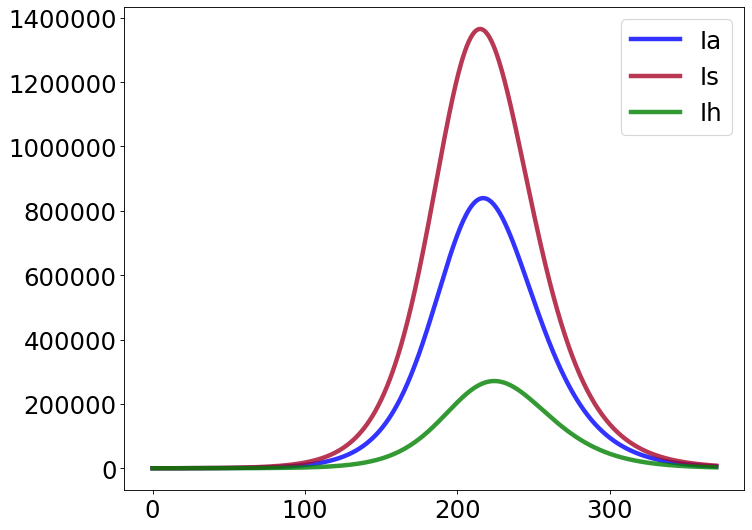

In [7]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

Is = model.Is(data); 
Ih = model.Ih(data); 
Ia  = model.Ia(data); 
plt.rcParams.update({'font.size': 22})
#plt.plot(totCases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.plot(data['t'], Ia.sum(axis=1), '-', lw=4, color='b', label='Ia', alpha=0.8)
plt.plot(data['t'], Is.sum(axis=1), '-', lw=4, color='#A60628', label='Is', alpha=0.8)
plt.plot(data['t'], Ih.sum(axis=1), '-', lw=4, color='g', label='Ih', alpha=0.8)
plt.legend()